In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.integrate as spi
import matplotlib.pyplot as plt
options={'limit':10000}

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data

In [2]:
d = pd.read_parquet("ETHUSD_ticks_2021_2023.parquet")

In [3]:
d

,timestamp,askp,bidp,askv,bidv,price,sprice,pricediff
0,2021-01-01 22:00:00.003,0.07319,0.07278,750,750,0.072985,0.072980,-0.000005
1,2021-01-01 22:00:00.818,0.07325,0.07271,400,83,0.072980,0.072975,-0.000005
2,2021-01-01 22:00:01.849,0.07318,0.07277,750,750,0.072975,0.072985,0.000010
3,2021-01-01 22:00:02.000,0.07319,0.07278,750,750,0.072985,0.072975,-0.000010
4,2021-01-01 22:00:02.556,0.07318,0.07277,750,750,0.072975,0.072965,-0.000010
...,...,...,...,...,...,...,...,...
95802611,2022-12-28 23:59:56.618,0.11927,0.11874,2,540,0.119005,0.118995,-0.000010
95802612,2022-12-28 23:59:56.681,0.11927,0.11872,600,540,0.118995,0.119005,0.000010
95802613,2022-12-28 23:59:56.938,0.11927,0.11874,2,540,0.119005,0.118995,-0.000010
95802614,2022-12-28 23:59:58.872,0.11927,0.11872,600,540,0.118995,0.119005,0.000010


In [4]:
np.nanmin(d.askv), np.nanmax(d.askv), np.nanmin(d.bidv), np.nanmax(d.bidv)

(1, 8000, 1, 8000)

### Slides 
https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/cfm-imperial-institute-of-quantitative-finance/events/imperial-eth-2016/Rama-Cont-1.pdf

In [5]:
history = {}

In [6]:
def calc_integral(n, p):
    if (n,p) in history:
        return history[(n, p)]
    integrand = lambda t :((2 - np.cos(t) - np.sqrt( (2-np.cos(t))**2 - 1 ))**p)*np.sin(n*t)*np.cos(t/2)/np.sin(t/2)
    a = 0.
    b = np.pi
    result, error = spi.nquad(integrand, [[a, b]], opts=options)
    history[(n, p)]  = result/np.pi
    return history[(n, p)]

#### Calculating probability that the next price move is an increase based on L1 OB data

In [7]:
integrals = []
bidv = d.bidv.apply(lambda x: float(x))
askv = d.askv.apply(lambda x: float(x))
for i in tqdm(range(len(d.bidv))):
    integrals.append(calc_integral(bidv[i], askv[i]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95802616/95802616 [05:43<00:00, 278754.14it/s]


In [8]:
d["p"] = integrals

<AxesSubplot:>

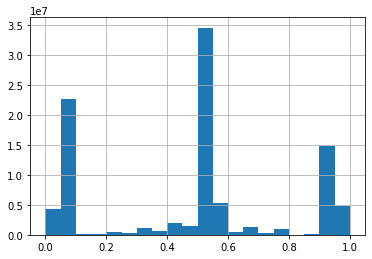

In [10]:
d.p.hist(bins = 20)

### Finding best cutoff points

In [25]:
cutoffs = []
longaccuracys = []
shortaccuracys = []
for i in tqdm(range(1, 100)):
    c = i/100
    cutoffs.append(c)
    longpredictions = d[d.p > c]
    shortpredictions = d[d.p < c]
    longaccuracys.append(100*np.sum(longpredictions.pricediff > 0) / len(longpredictions))  
    shortaccuracys.append(100*np.sum(shortpredictions.pricediff > 0) / len(shortpredictions)) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [17:09<00:00, 10.40s/it]


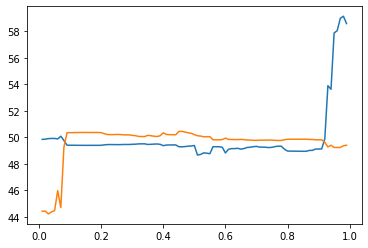

In [27]:
plt.plot(cutoffs, longaccuracys)
plt.plot(cutoffs, shortaccuracys)

In [28]:
print("Best long cutoff point about: ", cutoffs[np.argmax(longaccuracys)], "with accuracy: ", np.nanmax(longaccuracys))

Best long cutoff point about:  0.98 with accuracy:  59.12645410956293


In [29]:
print("Best short cutoff point about: ", cutoffs[np.argmax(shortaccuracys)], "with accuracy: ", np.nanmax(shortaccuracys))

Best short cutoff point about:  0.46 with accuracy:  50.44856373160831
